## Electric Energy Load Demand Forecasting for Rural Area

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
# function to read load data 
def data_reader(file_name):
    data = pd.read_excel(file_name, parse_dates=True, index_col='Time', usecols=range(2))
    return data

# function to read weather data
def weather_reader(file_name):
    weather = pd.read_excel(file_name, parse_dates=True, index_col='Time measured')
    return weather

# function for concatenating load data and weather data for training
def concat_data(file_name_load, file_name_weather):
    train_data = pd.concat([file_name_load, file_name_weather], axis=1)
    return train_data

In [216]:
# Load weather & load time-series data
load_data = data_reader('Index_Bjønntjønn_2014_2018.xlsx')
weather_data = weather_reader('bo_temp_2014_2018.xlsx')
weather_data = weather_data.interpolate()

# Concatenate
dataframe = concat_data(load_data, weather_data)

# Renaming columns for easier interpreting:
dataframe = dataframe.rename(columns={"Total":"Load","Middeltemperatur i 2m høyde (TM)": "Temperature"})

In [217]:
dataframe.head()

,Load,Temperature
2014-01-01 01:00:00,227.0,2.9
2014-01-01 02:00:00,216.0,3.0
2014-01-01 03:00:00,197.0,3.0
2014-01-01 04:00:00,198.0,3.1
2014-01-01 05:00:00,198.0,3.5


In [ ]:
def show_plots(data, time_start, time_end=None):
    # Ploting time-series data with different time ranges
    fig, ax = plt.subplots(figsize=(7,4.5))
    ax2 = ax.twinx()
    data['Load'].loc[time_start:time_end].plot(c='seagreen', label='Load', ax=ax)
    if time_end is None:
        data['Temperature'].loc[time_start].plot(c='darkorange', label='Temperature', ax=ax2)
    else:
        data['Temperature'].loc[time_start:time_end].plot(c='darkorange', label='Temperature', ax=ax2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_ylabel('Load', fontsize=12, fontweight='bold', color='seagreen')
    ax2.set_ylabel('Temperature', fontsize=12, fontweight='bold', color='darkorange')
    fig.tight_layout()
    plt.show()
    return

In [ ]:
# Time-series for 2018
show_plots(dataframe, '2017')

In [ ]:
# Time-series for June to August 2018
show_plots(dataframe, '2018-06', '2018-08')

In [ ]:
show_plots(dataframe, '2018-06-01', '2018-06-07')

### Multivariate multi-step load forecasting with feed-forward neural networks

In [ ]:
# Hard-coding holiday dates
holiday_dates = {
    # 2014 year
    '2014-Jan-1st': ('2014-01-01', None),  # single day
    '2014-Easter': ('2014-04-14', '2014-04-21'),  # date range
    '2014-May-1st': ('2014-05-01', None),
    '2014-Pentecost': ('2014-06-07', '2014-06-10'),
    '2014-Xmas': ('2014-12-21', '2014-12-31'),
    # 2015 year
    '2015-Jan-1st': ('2015-01-01', None),
    '2015-Easter': ('2015-03-30', '2015-04-06'),
    '2015-May-1st': ('2015-05-01', None),  # Friday
    '2015-Ascension': ('2015-05-14', None),
    '2015-Pentecost': ('2014-05-24', '2014-05-25'),
    '2015-Xmas': ('2015-12-23', '2015-12-31'),
    # 2016 year
    '2016-Jan-1st': ('2016-01-01', None),
    '2016-Easter': ('2016-03-21', '2016-03-28'),
    '2016-May-1st': ('2015-05-01', None),  # Sunday
    '2016-Ascension': ('2016-05-05', None),
    '2016-Pentecost': ('2016-05-16', '2016-05-17'),
    '2016-Xmas': ('2016-12-26', '2016-12-31'),
    # 2017 year
    '2017-Jan-1st': ('2017-01-01', None),
    '2017-Easter': ('2017-04-10', '2017-04-17'),
    '2017-May-1st': ('2017-05-01', None),  # Monday
    '2017-May-17th': ('2017-05-17', None),  # Wednesday
    '2017-Ascension': ('2017-05-25', None),
    '2017-Pentecost': ('2017-06-05', None),
    '2017-Xmas': ('2017-12-25', '2017-12-31'),
    # 2018 year
    '2018-Jan-1st': ('2018-01-01', None),
    '2018-Easter': ('2018-03-26', '2018-04-02'),
    '2018-May-1st': ('2018-05-01', None),  # Tuesday
    '2018-Ascension': ('2017-05-10', None),  # Thursday
    '2018-May-17th': ('2017-05-17', None),
    '2018-Pentecost': ('2018-05-21', None),
    '2018-Xmas': ('2018-12-24', '2018-12-31')
}

In [ ]:
def engineer_features(dataframe, holiday_dates, columns, time_lags=24, 
                      steps_ahead=1, drop_nan_rows=True):
    """Engineering features
    
    Load data features column names with underscore (i.e. Load_1h, Load_2h, etc.) 
    represent time-lags (t-1, t-2, ...), while those with plus sign (i.e. Load+1h, 
    Load+2h, etc.) represent future time-steps (t+1, t+2, ...); column with name
    Load+0h represents current load at time instant t. 
    
    Parameters
    ----------
    dataframe: pandas dataframe
        original dataframe with time-series data
    holiday_dates: dictionary
        dictionary with tuples specifying local holiday dates or date-ranges
    columns: list
        list of column names from the dataframe which are used for the 
        features engineering (i.e. time-lags)
    time_lags: int
        number of time lags for use with feature engineering
    steps_ahead: int
        number of steps ahead for multi-step forecasting (steps_ahead=1
        means single-step ahead forecasting)
    drop_nan_rows: bool
        True/False indicator to drop rows with NaN values

    Returns
    -------
    dataframe: pandas dataframe 
        dataframe augmented with additional features
    """
    
    # Make a copy of the original dataframe
    data = dataframe[columns].copy()
            
    # Features engineering
    for col in data.columns:
        for i in range(1, time_lags+1):
            # Shift data by lag of 1 to time_lags (default: 24) hours
            data[col+'_{:d}h'.format(i)] = data[col].shift(periods=i)  # time-lag
        data[col+'_diff'] = data[col].diff()  # first-difference
        data[col+'_week'] = data[col].shift(periods=24*7)  # previous week
    
    # Hour-of-day indicators with cyclical transform
    dayhour_ind = data.index.hour
    data['hr_sin'] = np.sin(dayhour_ind*(2.*np.pi/24))
    data['hr_cos'] = np.cos(dayhour_ind*(2.*np.pi/24))
    
    # Day-of-week indicators with cyclical transform
    weekday_ind = data.index.weekday
    data['week_sin'] = np.sin(weekday_ind*(2.*np.pi/7))
    data['week_cos'] = np.cos(weekday_ind*(2.*np.pi/7))

    # Weekend as a binary indicator
    data['weekend'] = np.asarray([0 if ind <= 4 else 1 for ind in weekday_ind])

    # Month indicators with cyclical transform
    month_ind = data.index.month
    data['mnth_sin'] = np.sin((month_ind-1)*(2.*np.pi/12))
    data['mnth_cos'] = np.cos((month_ind-1)*(2.*np.pi/12))
    
    # Holidays as a binary indicator
    data['holidays'] = 0
    for holiday, date in holiday_dates.items():
        if date[1] is None:
            # Single day
            data.loc[date[0], 'holidays'] = 1
        else:
            # Date range
            data.loc[date[0]:date[1], 'holidays'] = 1
    
    # Forecast horizont
    if steps_ahead == 1:
        # Single-step forecasting
        data['Load+0h'] = data['Load'].values
    else:
        # Multi-step forecasting
        for i in range(steps_ahead):
            data['Load'+'+{:d}h'.format(i)] = data['Load'].shift(-i)
    del data['Load']
    
    if drop_nan_rows:
        # Drop rows with NaN values
        data.dropna(inplace=True)
        
    return data

In [ ]:
def train_test_split(dataframe, start_date, window_days=100, train_percent=80.,
                     return_arrays=False):
    """Train and test data set split
    
    Parameters
    ----------
    dataframe: pandas dataframe
        dataframe augmented with additional features
    start_date: string
        starting date of the time-series 
    window_days: int
        size of the data window in days
    train_percent: float
        percentage of the data window size to use for creating the 
        training data set (the rest is used for testing)
    return_arrays: bool
        True/False indicator which defines the type of output; if 
        True function returns numpy arrays; if False it returns
        pandas dataframes
    
    Returns
    -------
    X_train: dataframe or array
        training data 2D array of input features
    y_train: dataframe or array
        training data array of output values
    X_test: dataframe or array
        testing/validation data 2D array of input features
    y_test: dataframe or array
        testing/validation data array of output values
    """
    data = dataframe.copy()
    if window_days*24 > data.values.shape[0]:
        raise ValueError('Variable window_days has too large value: {}*24h = {} > {}, \
            which is more than there is data!'.format(window_days, window_days*24, 
                                                      data.values.shape[0]))
    
    # Split dataframe into X, y
    columns = data.columns.values
    outputs = [col_name for col_name in columns if 'Load+' in col_name]
    inputs = [col_name for col_name in columns if col_name not in outputs]
    # inputs (features)
    X = data[inputs]
    # outputs
    y = data[outputs]
    
    # Training period
    train_percent = train_percent/100.
    st = pd.to_datetime(start_date)  # start date
    et = st + dt.timedelta(days=int(train_percent*window_days))  # end date
    X_train = X.loc[st:et]
    y_train = y.loc[st:et]
    
    # Testing / Validation period
    sv = et 
    ev = sv + dt.timedelta(days=int((1-train_percent)*window_days)+1)
    X_test = X.loc[sv:ev]
    y_test = y.loc[sv:ev]
        
    if return_arrays:
        # Returning numpy arrays
        return X_train.values, y_train.values, X_test.values, y_test.values
    else:
        # Returning pandas dataframes
        return X_train, y_train, X_test, y_test

In [ ]:
STEPS_AHEAD = 24
# 24-hours ahead forecasting (steps_ahead=24)
data_features = engineer_features(dataframe, holiday_dates, 
                                  columns=['Load', 'Temperature'], 
                                  steps_ahead=STEPS_AHEAD)

In [ ]:
START_DATE = '2014-01-09'
WINDOW_SIZE_DAYS = 400
# Split dataset into training and test/validation sets
X_train, y_train, X_test, y_test = train_test_split(
    data_features, start_date=START_DATE, 
    window_days=WINDOW_SIZE_DAYS)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# Scale and transform input data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
BATCH_SIZE = 256
EPOCHS = 400
WAIT = 50  # patience
LR = 1e-3  # learning rate
# Feed-forward and fixed funnel-shaped deep ANN
# tf.keras functional API
input_layer = keras.layers.Input(shape=X_train_sc.shape[1:])
x = keras.layers.Dense(units=1024, activation='relu')(input_layer)
x = keras.layers.Dropout(0.2)(x)  # regularization
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)  # regularization
x = keras.layers.Dense(units=256, activation='relu')(x)
output_layer = keras.layers.Dense(STEPS_AHEAD)(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
adam = keras.optimizers.Adam(learning_rate=LR, decay=LR/EPOCHS)
model.compile(loss='mae', optimizer=adam, metrics=['mae', 'mape'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, 
                                           patience=WAIT, verbose=1,
                                           restore_best_weights=True)
history = model.fit(X_train_sc, y_train.values, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(X_test_sc, y_test.values),
                    callbacks=[early_stop], shuffle=True, verbose=0,
                    use_multiprocessing=True)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
print('MAE val_loss at final epoch is {:.2f}, while min. val_loss is {:.2f}.'
      .format(val_loss[-1], min(val_loss)))
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE loss value')
plt.show()

In [ ]:
def prepare_test_data(dataframe, start_date, window_days, test_size=1):
    """ Prepare test data
    
    Arguments
    ---------
    dataframe: pandas dataframe
        original dataframe with features
    start_date: string
        starting date for the time-series previously used
        in creating the train and test/validation data sets
    window_days: int
        size of the data window in days previously used
        in creating the train and test/validation data sets
    test_size: int
        number of time-steps (hours) for walk-forward testing
        
    Returns
    -------
    X_new: numpy array
        walk-forward testing data set as numpy array
    """
    data = dataframe.copy()
    date_test_start = pd.to_datetime(start_date) + dt.timedelta(days=window_days)
    date_test_end = date_test_start + dt.timedelta(hours=test_size)
    
    columns = data.columns.values
    outputs = [col_name for col_name in columns if 'Load+' in col_name]
    inputs = [col_name for col_name in columns if col_name not in outputs]
    
    if test_size == 1:
        # Array with a single value needs to be reshaped accordingly
        X_new = data[inputs].loc[date_test_start].values.reshape(1,-1)
    else:
        X_new = data[inputs].loc[date_test_start:date_test_end].values[:-1]

    return X_new

In [ ]:
TEST_SIZE = 12  # walk-forward for 12 hours
X_new = prepare_test_data(data_features, START_DATE, WINDOW_SIZE_DAYS, TEST_SIZE)

In [ ]:
# Transform values using scaler
X_new_sc = scaler.transform(X_new)

In [ ]:
# Predict on new values using model
y_pred = model.predict(X_new_sc)

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Mean absolute percentage error
    
    Parameters
    ----------
    y_true: numpy array
        array holding true values
    y_pred: numpy array
        array holding predictions
    
    Returns
    -------
    mape: float
        mean absolute percentage error value
    """
    if not isinstance(y_true, np.ndarray):
        raise TypeError('Variable y_true is not a numpy array.')
    if not isinstance(y_pred, np.ndarray):
        raise TypeError('Variable y_pred is not a numpy array.')
    if len(y_true.shape) > 1 or len(y_pred.shape) > 1:
        raise TypeError('Arrays need to be one-dimensional.')
        
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100.
    
    return mape

In [ ]:
# Plotting multi-step ahead predictions using the walk-forward method
if TEST_SIZE == 1: 
    raise ValueError('TEST_SIZE: Need a multi-step ahead predictions!')
date_start = pd.to_datetime(START_DATE) + dt.timedelta(days=WINDOW_SIZE_DAYS)
for i in range(TEST_SIZE):
    date_end = date_start + dt.timedelta(hours=23)
    y_true = data_features['Load+0h'].loc[date_start:date_end]
    y_values = pd.DataFrame(y_true)
    y_values = y_values.rename(columns={'Load+0h':'Actual'})
    y_values['Predicted'] = y_pred[i,:]
    
    # Absolute percentage error
    y_values['APE'] = np.abs((y_values['Actual'] - y_values['Predicted'])/y_values['Actual'])*100.
    # Mean absolute percentage error
    mape = mean_absolute_percentage_error(y_values['Actual'].values, y_values['Predicted'].values)
    print('MAPE = {:.2f} (%)'.format(mape))
    
    # Plot figure
    y_values[['Actual', 'Predicted']].plot(figsize=(5.5,3.5))
    plt.ylabel('Load')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    date_start = date_start + dt.timedelta(hours=1)

### Multivariate multi-step load forecasting with convolutional neural networks

In [218]:
def samples_timesteps_features(dataframe, columns, start_date, timesteps=48, 
                               steps_ahead=24, window_days=100, train_percent=80.):
    """
    Restructure original dataframe with columns time-series data into a 3D array
    of shape: [samples, timesteps, features] for the use with convolutional layers.
    First dimension of the output array is the number of samples, which is determined
    automatically from the size of the window. Second dimension is determined by the 
    number of timesteps and defines how many time steps from the past will be used in
    the internal processing of the convolutional layer. The third dimension is the
    number of features in the original dataset, which is defined by the number of 
    columns that are used from the original dataframe.
    
    Parameters
    ----------
    dataframe: pandas dataframe
        dataframe with the original time-series data
    columns: list
        list of column names from the dataframe which are used
    start_date: string
        starting date of the time-series 
    timesteps: int
        number of time steps from the past for creating output arrays
    steps_ahead: int
        number of time steps into the future for making predictions
    window_days: int
        size of the data window in days
    train_percent: float
        percentage of the data window size to use for creating the 
        training data set (the rest is used for testing)
    
    Returns
    -------
    mean_std_values: dictionary
        dictionary with tuples holding mean value and standard
        deviation for each of the columns in the dataframe
    X_train: dataframe or array
        training data 2D array of input features
    y_train: dataframe or array
        training data array of output values
    X_test: dataframe or array
        testing/validation data 2D array of input features
    y_test: dataframe or array
        testing/validation data array of output values
    """
    data = dataframe.copy()
    if window_days*24 > data.values.shape[0]:
        raise ValueError('Variable window_days has too large value: {}*24h = {} > {}, \
            which is more than there is data!'.format(window_days, window_days*24, 
                                                      data.values.shape[0]))
    
    # Training period
    # ---------------
    train_percent = train_percent/100.
    st = pd.to_datetime(start_date)  # start date
    et = st + dt.timedelta(days=int(train_percent*window_days))  # end date
    train = data.loc[st:et].values
    
    # Standardize and transform training data set
    mean_std_values = {}
    for i, column in enumerate(columns):
        # Calculate mean and standard deviation only
        # from the training data set values
        mu = train[:,i].mean()
        sd = train[:,i].std()
        mean_std_values[column] = (mu, sd)
        # Standardize training data
        train[:,i] = (train[:,i] - mu)/sd
    
    # Create overlapping windows with training data
    X_train = []; y_train = []
    start = 0
    for i in range(len(train)):
        # define the end of the input sequence
        in_end = start + timesteps
        out_end = in_end + steps_ahead
        # ensure we have enough data
        if out_end <= len(train):
            X_train.append(train[start:in_end, :])
            y_train.append(train[in_end:out_end, 0])
        # move along one time step
        start += 1
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)

    # Testing / Validation period
    # ---------------------------
    sv = et 
    ev = sv + dt.timedelta(days=int((1-train_percent)*window_days)+1)
    test = data.loc[sv:ev].values
    
    # Transform testing/validation data set
    for i, column in enumerate(columns):
        # Use mean and standard deviation from the
        # training data set
        mu = mean_std_values[column][0]
        sd = mean_std_values[column][1]
        # Standardize test data
        test[:,i] = (test[:,i] - mu)/sd
    
    # Create overlapping windows with testing data
    X_test = []; y_test = []
    start = 0
    for i in range(len(test)):
        # define the end of the input sequence
        in_end = start + timesteps
        out_end = in_end + steps_ahead
        # ensure we have enough data
        if out_end <= len(test):
            X_test.append(test[start:in_end, :])
            y_test.append(test[in_end:out_end, 0])
        # move along one time step
        start += 1
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
        
    return mean_std_values, X_train, y_train, X_test, y_test

In [219]:
# Training, Validation and Testing data sets
mean_std_values, X_train, y_train, X_validate, y_validate = samples_timesteps_features(
    dataframe, ['Load', 'Temperature'], start_date='2014-01-09', window_days=300)

In [220]:
mean_std_values

{'Load': (115.9109375, 83.6304819982522),
 'Temperature': (8.802282986111111, 8.494248181354642)}

In [221]:
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(5689, 48, 2) (5689, 24)
(1371, 48, 2) (1371, 24)


In [222]:
# Testing / Validation dataset (remove last 10 values)
X_test = X_validate[:-10,...]
y_test = y_validate[:-10,...]
print(X_test.shape)
print(y_test.shape)
# Testing dataset (using last 10 values from the validation dataset)
X_new = X_validate[-10:,...]
y_true = y_validate[-10:,...]
print(X_new.shape)
print(y_true.shape)

(1361, 48, 2)
(1361, 24)
(10, 48, 2)
(10, 24)


In [223]:
# Convolutional deep ANN
# tf.keras functional API
input_layer = keras.layers.Input(shape=(X_train.shape[1:]))
x = keras.layers.LSTM(units=32, return_sequences=True, activation='relu')(input_layer)
x = keras.layers.LSTM(units=64, activation='relu', dropout=0.1)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)  # regularization
output_layer = keras.layers.Dense(STEPS_AHEAD)(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
adam = keras.optimizers.Adam(learning_rate=LR, decay=LR/EPOCHS)
model.compile(loss='mae', optimizer=adam, metrics=['mae', 'mape'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, 
                                           patience=WAIT, verbose=1,
                                           restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop], shuffle=False, verbose=0,
                    use_multiprocessing=True)

Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping


MAE val_loss at final epoch is 0.24, while min. val_loss is 0.22.


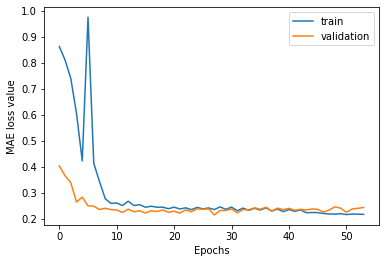

In [224]:
loss = history.history['loss']
val_loss = history.history['val_loss']
print('MAE val_loss at final epoch is {:.2f}, while min. val_loss is {:.2f}.'
      .format(val_loss[-1], min(val_loss)))
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE loss value')
plt.show()

In [244]:
y_pred = model.predict(X_new)
y_pred0 = y_pred[0,:]
y_pred0

array([-0.24154937, -0.2315311 , -0.32458562, -0.23857278, -0.19979994,
       -0.13437374, -0.15211038, -0.21285555, -0.24599846, -0.2258263 ,
       -0.22387365,  0.08987629, -0.17822146, -0.10847601, -0.30549923,
       -0.23603633, -0.27414396, -0.17589158, -0.31191206, -0.13369574,
       -0.37671384, -0.33013096, -0.2138901 , -0.21030459], dtype=float32)

In [245]:
y_true0 = y_true[0,:]
y_true0

array([-0.3337412 , -0.32178384, -0.3337412 , -0.32178384, -0.2380823 ,
       -0.22612494, -0.10655131, -0.17829549, -0.2380823 , -0.38157065,
       -0.26199703, -0.19025285, -0.21416757, -0.25003966, -0.1424234 ,
       -0.20221021, -0.27395439, -0.2380823 , -0.17829549, -0.16633812,
       -0.26199703, -0.39352801, -0.4294001 , -0.41744274])

In [246]:
mape = mean_absolute_percentage_error(y_true0, y_pred0)
print('MAPE = {:.2f} (%)'.format(mape))

MAPE = 37.25 (%)


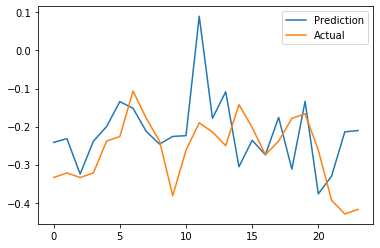

In [247]:
plt.plot(y_pred0, label='Prediction')
plt.plot(y_true0, label='Actual')
plt.legend()
plt.show()